In [1]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys

In [ ]:
#Label file:
import os

# Path to the extracted frames dataset
data_path = "/extracted_frames"

# Get the list of class names (folder names)
classes = os.listdir(data_path)

# Create label mappings
decoder = {class_name: i for i, class_name in enumerate(classes)}
encoder = {i: class_name for i, class_name in enumerate(classes)}

# Print the mappings to verify
print("Decoder (Class to Index):", decoder)
print("Encoder (Index to Class):", encoder)


Decoder (Class to Index): {'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'Normal-Videos-Part-1': 7}
Encoder (Index to Class): {0: 'Abuse', 1: 'Arrest', 2: 'Arson', 3: 'Assault', 4: 'Burglary', 5: 'Explosion', 6: 'Fighting', 7: 'Normal-Videos-Part-1'}


In [ ]:
import os
path = "/extracted_frames"
print("Classes found:", os.listdir(path))

Classes found: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal-Videos-Part-1']


In [ ]:
id = []
path = "/extracted_frames"  # Path to extracted frames directory, created earlier

for class_name in os.listdir(path):  # Iterate through class folders
    class_path = os.path.join(path, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        frames = sorted(os.listdir(class_path))  # Sort frames to maintain order
        frame_paths = [os.path.join(class_path, frame) for frame in frames if frame.endswith(".jpg")]  # Get full paths
        
        if frame_paths:  # Only add if frames exist
            id.append((class_name, frame_paths))

print(f"Processed {len(id)} class folders with frames.")



Processed 8 class folders with frames.


In [11]:
class video_dataset(Dataset):
    def __init__(self, frame_list, sequence_length=16, transform=None, im_size=128):
        self.frame_list = frame_list  # (label, frame_paths) tuples
        self.transform = transform
        self.sequence_length = sequence_length
        self.im_size = im_size

    def __len__(self):
        return len(self.frame_list)

    def __getitem__(self, idx):
        label, frame_paths = self.frame_list[idx]  # Get list of frame paths

        # Ensure we have at least `sequence_length` frames
        if len(frame_paths) < self.sequence_length:
            raise ValueError(f"Not enough frames in {frame_paths[0]} (found {len(frame_paths)})")

        seq_img = []
        for i in range(self.sequence_length):
            frame_path = frame_paths[i]  # Get frame path
            img = cv2.imread(frame_path)  # Read frame
            
            if img is None:
                raise ValueError(f"Error loading image: {frame_path}")

            img = cv2.resize(img, (self.im_size, self.im_size))  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format
            
            if self.transform:
                img = self.transform(img)  # Apply transformation
            
            seq_img.append(img)

        # Stack frames into a tensor
        seq_image = torch.stack(seq_img)  # Shape: (sequence_length, C, H, W)
        seq_image = seq_image.permute(1, 0, 2, 3)  # Reshape to (C, sequence_length, H, W)

        return seq_image, decoder[label]  # Return the tensor and label


In [13]:
class video_dataset(Dataset):
    def __init__(self, frame_list, sequence_length=16, transform=None, im_size=128):
        self.frame_list = frame_list  # (label, frame_paths) tuples
        self.transform = transform
        self.sequence_length = sequence_length
        self.im_size = im_size

    def __len__(self):
        return len(self.frame_list)

    def __getitem__(self, idx):
        label, frame_paths = self.frame_list[idx]  # Get list of frame paths

        # Ensure we have at least `sequence_length` frames
        if len(frame_paths) < self.sequence_length:
            raise ValueError(f"Not enough frames in {frame_paths[0]} (found {len(frame_paths)})")

        seq_img = []
        for i in range(self.sequence_length):
            frame_path = frame_paths[i]  # Get frame path
            img = cv2.imread(frame_path)  # Read frame
            
            if img is None:
                raise ValueError(f"Error loading image: {frame_path}")

            img = cv2.resize(img, (self.im_size, self.im_size))  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color format
            
            if self.transform:
                img = self.transform(img)  # Apply transformation
            
            seq_img.append(img)

        # Stack frames into a tensor
        seq_image = torch.stack(seq_img)  # Shape: (sequence_length, C, H, W)
        seq_image = seq_image.permute(1, 0, 2, 3)  # Reshape to (C, sequence_length, H, W)

        return seq_image, decoder[label]  # Return the tensor and label


In [15]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]

# Data Transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Debugging: Check first few entries in 'id' list
#print("Sample data entries:", id[:5])  # Ensure correct format

# Create Dataset
train_data = video_dataset(id, sequence_length=16, transform=train_transforms)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=1, num_workers=0, shuffle=True)

# Store in dictionary
dataloaders = {'train': train_loader}



In [17]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]


train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data = video_dataset(id,sequence_length = 16,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 1,num_workers = 4 ,shuffle = True)
dataloaders = {'train':train_loader}

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

class resnet50(nn.Module):
    def __init__(self, class_num=8, pretrained=True):
        super(resnet50, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        in_features = self.model.fc.in_features  # Get input size of FC layer
        self.model.fc = nn.Linear(in_features, class_num)  # Replace FC layer

    def forward(self, x):
        return self.model(x)


In [21]:
from model import SlowFast
model = SlowFast(class_num=27)  # Adjust class_num if needed
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

print("Model is on:", next(model.parameters()).device)  # Should print "cuda" or "cpu"
print(model)  # Check if last FC layer is correctly modified


Model is on: cpu
SlowFast(
  (fast_conv1): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
  (fast_bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fast_relu): ReLU(inplace=True)
  (fast_maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
  (fast_res1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(8, 8, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(8, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [57]:
from model import resnet50
import torch

model = resnet50(class_num=8).to('cuda' if torch.cuda.is_available() else 'cpu')
print("Model is on:", next(model.parameters()).device)


Model is on: cpu


In [23]:
from torch.optim.lr_scheduler import OneCycleLR

device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

num_epochs = 20
steps_per_epoch = len(train_loader)
max_lr = 1e-3  # Set the max LR

scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=num_epochs)


In [ ]:
import os
import sys
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Reduce dataset size if needed (Uncomment to use subset)
def limit_dataset(dataset, max_samples=5000):  # Adjust max_samples as needed
    return Subset(dataset, range(min(len(dataset), max_samples)))

# ✅ Define correct path
weights_dir = os.path.join(os.getcwd(), "Criminal_Activity_Detection", "weights_crime")
os.makedirs(weights_dir, exist_ok=True)

# ✅ Dataloader (Optimized)
batch_size = 8  # Start with 8, increase if memory allows
num_workers = 4  # Use 4 for faster data loading
pin_memory = True if torch.cuda.is_available() else False

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory
)

dataloaders = {"train": train_loader, "val": val_loader}

# ✅ Initialize tracking variables
acc_all = []
loss_all = []

# ✅ Training Loop
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")

    for phase in ["train", "val"]:
        print(f"\n--- Phase: {phase} ---")

        model.train() if phase == "train" else model.eval()
        epoch_metrics = {"loss": [], "acc": []}

        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                predictions = model(X)
                loss = cls_criterion(predictions, y)

                # Compute accuracy
                acc = 100 * (predictions.argmax(1) == y).float().mean().item()
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    scheduler.step()  # Adjust learning rate

            # ✅ Display Progress
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %.4f, Acc: %.2f%%]"
                % (epoch, num_epochs, batch_i, len(dataloaders[phase]), loss.item(), acc)
            )
            sys.stdout.flush()

            # ✅ Free GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # ✅ Print epoch summary
        print(f"\n{phase} - Avg Loss: {np.mean(epoch_metrics['loss']):.4f}, Avg Acc: {np.mean(epoch_metrics['acc']):.2f}%")

        # ✅ Save model checkpoint (Only after validation)
        if phase == "val":
            torch.save(model.state_dict(), os.path.join(weights_dir, f"c3d_epoch_{epoch}.pth"))

        # ✅ Store training metrics
        if phase == "train":
            acc_all.append(np.mean(epoch_metrics["acc"]))
            loss_all.append(np.mean(epoch_metrics["loss"]))

print("\n✅ Training Complete!")


In [ ]:
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch} ---")  # Check if epoch starts

    for phase in dataloaders:
        print(f"\n--- Phase {phase} ---")  # Check if phase starts

        epoch_metrics = {"loss": [], "acc": []}

        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            print(f"Processing batch {batch_i + 1}/{len(dataloaders[phase])}")  # Debug batch loading

            image_sequences = X.to(device)  
            labels = y.to(device)

            optimizer.zero_grad()
            predictions = model(image_sequences)

            loss = cls_criterion(predictions, labels)
            acc = 100 * (predictions.argmax(1) == labels).float().mean().item()

            print(f"Batch {batch_i}: Loss = {loss.item()}, Accuracy = {acc}%")  # Debug loss/acc

            loss.backward()
            optimizer.step()

            # Track metrics
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)

            if phase == 'train':
                scheduler.step()

        print(f"\n{phase} , acc: {np.mean(epoch_metrics['acc'])}%")  



--- Epoch 0 ---

--- Phase train ---


In [ ]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [12]:
loss_all

[1.5113742563822499,
 1.305457015968349,
 1.17912877885174,
 1.041740705569585,
 0.8091797970201327,
 0.6143478534809531,
 0.4010123163461685,
 0.3424767658590726,
 0.22346783888666596,
 0.18811332580705756,
 0.1250801009538511,
 0.09738352649832425,
 0.07329675657291936,
 0.06421710863777491,
 0.03668630755927465,
 0.029382538033402673,
 0.02058421796587504,
 0.01861625916609481,
 0.012762131824340994,
 0.011054905242027213]

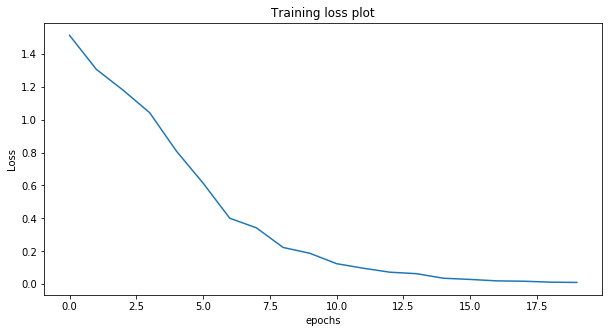

In [13]:
error_plot(loss_all)

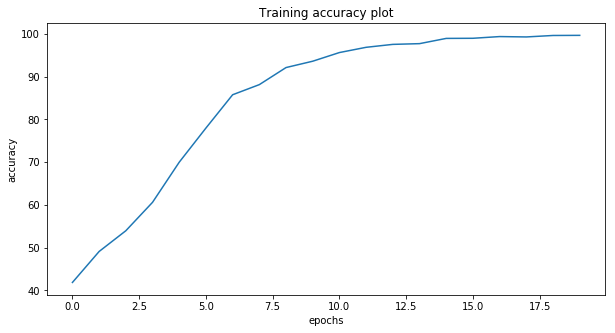

In [15]:
acc_plot(acc_all)